Generative Adversarial Networks (GANs)
======================================
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder. If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [27]:
import sys

In [28]:
# install pytorch (http://pytorch.org/) and tqdm if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118  #uncomment to enforce cuda 11.8
if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm

%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

print(f"Using Pytorch {torch.__version__}.")

Using Pytorch 2.6.0+cu124.


Parameter Settings
-------------------


In [29]:
latent_dim = 10       # latent dimension
num_epochs = 50       # number of training epochs
batch_size = 512      # batch size (you may increase it to gain time, but check not to
                      # exceed your GPU memory limit)
learning_rate = 1e-3  # learning rate of the training algorithm
use_gpu = True        # use the GPU (strongly recommended for speed)
compile = False       # not well implemented on Colab (requires a personal installation with a
                      # relatively recent CUDA-compatible GPU)

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images.

In [30]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.ToTensor()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mnist_dims = train_dataloader.dataset[0][0].shape[1:]
mnist_dim = train_dataloader.dataset[0][0].numel()

Vanilla GAN
-----------
We define here the architecture of the different elements of the model. The init defines the different layers and the forward defines what happens when the model is called. We refer to it as the vanilla GAN as it the model in a very simple form.

In [31]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, mnist_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))
        return x.view(-1, *mnist_dims)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(mnist_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

We can now instantiate and load the model onto the GPU if relevant.

In [32]:
generator = Generator()
discriminator = Discriminator()

if compile:
  generator = torch.compile(generator)
  discriminator = torch.compile(discriminator)
  print("Using a compiled model (faster).")

if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))


Using the CPU.
Number of parameters for generator: 1463312 and discriminator: 1460225


Training
--------
Be careful, the training can be relatively long, even with a GPU on Colab.

In [33]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True):
        # moving the batch onto GPU if relevant
        image_batch = image_batch.to(device)

        # get dataset image and create real and fake labels for use in the loss
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print(f"\tAverage loss generator vs. discrim.: {gen_loss_avg[-1]:.3} vs. {disc_loss_avg[-1]:.3}")

print("Done.")

Training...


Epoch 1: 100%|██████████| 118/118 [00:51<00:00,  2.27it/s]


	Average loss generator vs. discrim.: 0.821 vs. 0.7


Epoch 2: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


	Average loss generator vs. discrim.: 0.861 vs. 0.697


Epoch 3: 100%|██████████| 118/118 [00:47<00:00,  2.47it/s]


	Average loss generator vs. discrim.: 0.872 vs. 0.693


Epoch 4: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]


	Average loss generator vs. discrim.: 0.946 vs. 0.686


Epoch 5: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


	Average loss generator vs. discrim.: 0.973 vs. 0.676


Epoch 6: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


	Average loss generator vs. discrim.: 0.995 vs. 0.661


Epoch 7: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


	Average loss generator vs. discrim.: 1.09 vs. 0.647


Epoch 8: 100%|██████████| 118/118 [00:47<00:00,  2.46it/s]


	Average loss generator vs. discrim.: 1.16 vs. 0.636


Epoch 9: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


	Average loss generator vs. discrim.: 1.24 vs. 0.61


Epoch 10: 100%|██████████| 118/118 [00:46<00:00,  2.52it/s]


	Average loss generator vs. discrim.: 1.31 vs. 0.605


Epoch 11: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


	Average loss generator vs. discrim.: 1.41 vs. 0.569


Epoch 12: 100%|██████████| 118/118 [00:46<00:00,  2.51it/s]


	Average loss generator vs. discrim.: 1.38 vs. 0.576


Epoch 13: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


	Average loss generator vs. discrim.: 1.38 vs. 0.564


Epoch 14: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


	Average loss generator vs. discrim.: 1.49 vs. 0.533


Epoch 15: 100%|██████████| 118/118 [00:48<00:00,  2.43it/s]


	Average loss generator vs. discrim.: 1.61 vs. 0.52


Epoch 16: 100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


	Average loss generator vs. discrim.: 1.64 vs. 0.508


Epoch 17: 100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


	Average loss generator vs. discrim.: 1.73 vs. 0.484


Epoch 18: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


	Average loss generator vs. discrim.: 1.74 vs. 0.487


Epoch 19: 100%|██████████| 118/118 [00:48<00:00,  2.43it/s]


	Average loss generator vs. discrim.: 1.76 vs. 0.478


Epoch 20: 100%|██████████| 118/118 [00:45<00:00,  2.59it/s]


	Average loss generator vs. discrim.: 1.88 vs. 0.455


Epoch 21: 100%|██████████| 118/118 [00:46<00:00,  2.55it/s]


	Average loss generator vs. discrim.: 1.93 vs. 0.448


Epoch 22: 100%|██████████| 118/118 [00:46<00:00,  2.55it/s]


	Average loss generator vs. discrim.: 2.02 vs. 0.439


Epoch 23: 100%|██████████| 118/118 [00:45<00:00,  2.59it/s]


	Average loss generator vs. discrim.: 2.05 vs. 0.423


Epoch 24: 100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


	Average loss generator vs. discrim.: 2.05 vs. 0.425


Epoch 25: 100%|██████████| 118/118 [00:46<00:00,  2.52it/s]


	Average loss generator vs. discrim.: 2.01 vs. 0.434


Epoch 26: 100%|██████████| 118/118 [00:45<00:00,  2.57it/s]


	Average loss generator vs. discrim.: 2.1 vs. 0.421


Epoch 27: 100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


	Average loss generator vs. discrim.: 2.1 vs. 0.424


Epoch 28: 100%|██████████| 118/118 [00:47<00:00,  2.47it/s]


	Average loss generator vs. discrim.: 2.14 vs. 0.421


Epoch 29: 100%|██████████| 118/118 [00:46<00:00,  2.56it/s]


	Average loss generator vs. discrim.: 2.13 vs. 0.421


Epoch 30: 100%|██████████| 118/118 [00:46<00:00,  2.54it/s]


	Average loss generator vs. discrim.: 2.21 vs. 0.416


Epoch 31: 100%|██████████| 118/118 [00:46<00:00,  2.54it/s]


	Average loss generator vs. discrim.: 2.18 vs. 0.415


Epoch 32: 100%|██████████| 118/118 [00:46<00:00,  2.54it/s]


	Average loss generator vs. discrim.: 2.23 vs. 0.404


Epoch 33: 100%|██████████| 118/118 [00:46<00:00,  2.51it/s]


	Average loss generator vs. discrim.: 2.27 vs. 0.405


Epoch 34: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


	Average loss generator vs. discrim.: 2.28 vs. 0.399


Epoch 35: 100%|██████████| 118/118 [00:45<00:00,  2.57it/s]


	Average loss generator vs. discrim.: 2.39 vs. 0.383


Epoch 36: 100%|██████████| 118/118 [00:46<00:00,  2.52it/s]


	Average loss generator vs. discrim.: 2.39 vs. 0.38


Epoch 37: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


	Average loss generator vs. discrim.: 2.41 vs. 0.385


Epoch 38: 100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


	Average loss generator vs. discrim.: 2.41 vs. 0.372


Epoch 39: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]


	Average loss generator vs. discrim.: 2.48 vs. 0.371


Epoch 40: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


	Average loss generator vs. discrim.: 2.59 vs. 0.366


Epoch 41: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


	Average loss generator vs. discrim.: 2.59 vs. 0.36


Epoch 42: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


	Average loss generator vs. discrim.: 2.56 vs. 0.356


Epoch 43: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


	Average loss generator vs. discrim.: 2.62 vs. 0.345


Epoch 44: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]


	Average loss generator vs. discrim.: 2.7 vs. 0.342


Epoch 45: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


	Average loss generator vs. discrim.: 2.68 vs. 0.339


Epoch 46: 100%|██████████| 118/118 [00:46<00:00,  2.54it/s]


	Average loss generator vs. discrim.: 2.79 vs. 0.326


Epoch 47: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


	Average loss generator vs. discrim.: 2.78 vs. 0.328


Epoch 48: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


	Average loss generator vs. discrim.: 2.79 vs. 0.324


Epoch 49: 100%|██████████| 118/118 [00:46<00:00,  2.54it/s]


	Average loss generator vs. discrim.: 2.79 vs. 0.327


Epoch 50: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]

	Average loss generator vs. discrim.: 2.81 vs. 0.325
Done.


You may save the obtained weights after training.

In [34]:
import os
if not os.path.exists('./pretrained'):
  os.mkdir('./pretrained')

torch.save(generator.state_dict(), './pretrained/my_vanilla_gan_generator.pth')
torch.save(discriminator.state_dict(), './pretrained/my_vanilla_gan_discriminator.pth')

If already saved, they can be loaded in the following way.

In [35]:
# first load your model to generate instances of the generator and discriminator (but don't train it)
generator.load_state_dict(torch.load('./pretrained/my_vanilla_gan_generator.pth'))
discriminator.load_state_dict(torch.load('./pretrained/my_vanilla_gan_discriminator.pth'))

<All keys matched successfully>

Training Curves
---------------

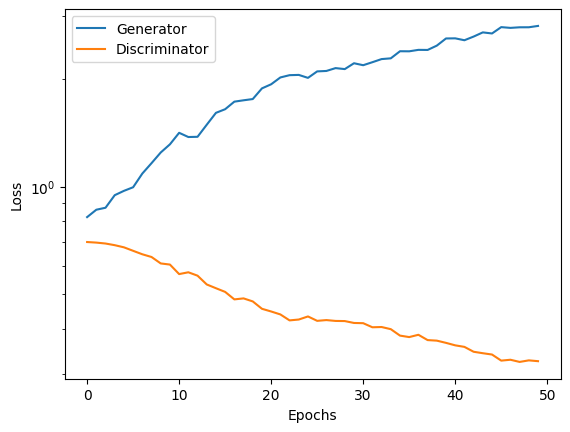

In [36]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.semilogy(gen_loss_avg, label='Generator')
plt.semilogy(disc_loss_avg, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interpolate in Latent Space
----------------------------

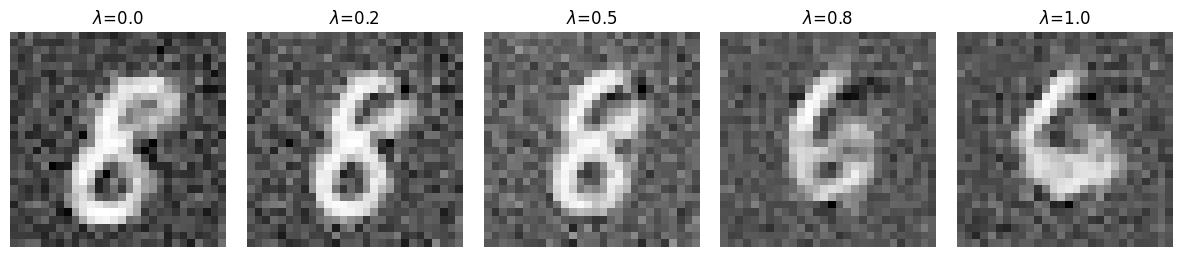

In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dim, device=device)
latent_2 = torch.randn(1, latent_dim, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,:,:].squeeze(), cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

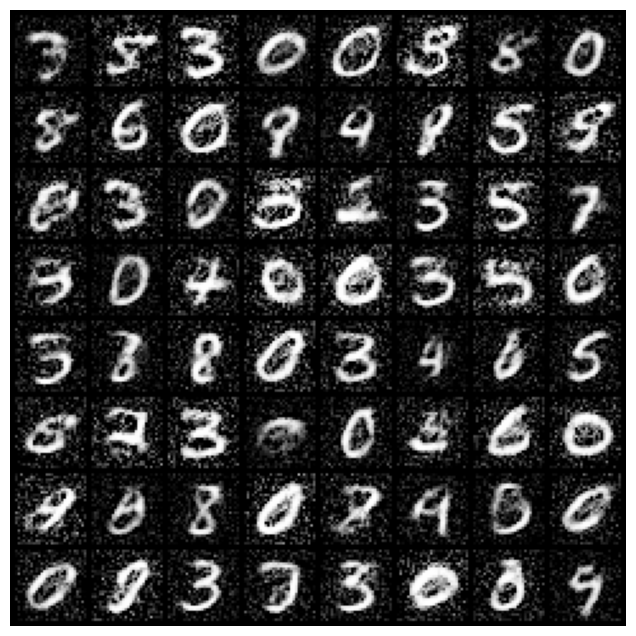

In [39]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn(n**2, latent_dim, device=device)
    fake_image_batch = generator(latent)
    if len(fake_image_batch.shape) == 3:
        fake_bimage_batch = fake_image_batch.unsqueeze(1)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

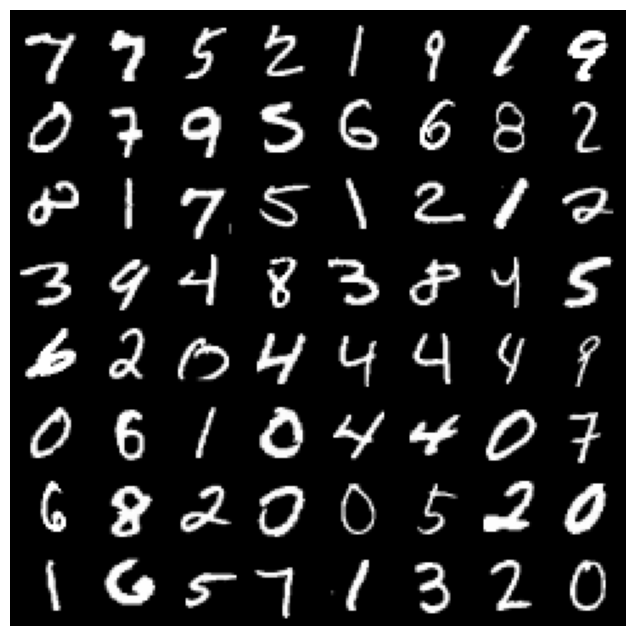

In [40]:
import random
data_iter= iter(train_dataloader)
images, labels = next(data_iter)  # images.shape: (512, 1, 28, 28)
# Randomly select 64 indices
sample_indices = random.sample(range(images.size(0)), 64)
sampled_images = images[sample_indices]

fig, ax = plt.subplots(figsize=(8, 8))
show_image(torchvision.utils.make_grid(sampled_images.data,nrow=n))
plt.axis('off')
plt.show()

A CNN as Backbone
-----------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters. Running this will shadow the alternative vanilla version above. You will still need to instantiate it.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

Don't hesitate to tweak the architecture to improve it.

In [24]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dim, latent_dim * 32, 5, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(latent_dim * 32)
        self.deconv2 = nn.ConvTranspose2d(latent_dim * 32, latent_dim * 16, 5, 1, 1)
        self.deconv2_bn = nn.BatchNorm2d(latent_dim * 16)
        self.deconv3 = nn.ConvTranspose2d(latent_dim * 16, latent_dim, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(latent_dim)
        self.deconv4 = nn.ConvTranspose2d(latent_dim, 1, 4, 2, 1)

    def forward(self, x):
        x = x[:, :, None, None]
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, latent_dim, 4, 2, 1)
        self.conv1_bn = nn.BatchNorm2d(latent_dim)
        self.conv2 = nn.Conv2d(latent_dim, latent_dim * 16, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(latent_dim * 16)
        self.conv3 = nn.Conv2d(latent_dim * 16, latent_dim * 32, 5, 1, 1)
        self.conv3_bn = nn.BatchNorm2d(latent_dim * 32)
        self.conv4 = nn.Conv2d(latent_dim * 32, latent_dim, 5, 1, 0)
        self.conv4_bn = nn.BatchNorm2d(latent_dim)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(latent_dim, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1_bn(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.fc(self.flatten(x)))
        return x

Again, you can save and load the trained weights.

In [25]:
torch.save(generator.state_dict(), './pretrained/my_cnn_gan_generator.pth')
torch.save(discriminator.state_dict(), './pretrained/my_cnn_gan_discriminator.pth')

In [26]:
generator.load_state_dict(torch.load('./pretrained/my_cnn_gan_generator.pth'))
discriminator.load_state_dict(torch.load('./pretrained/my_cnn_gan_discriminator.pth'))

<All keys matched successfully>

You can now have a look at the results of the model by running again the corresponding sections.